In [ ]:
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install yfinance
!pip install datetime
!pip install pyportfolioopt
# !pip install mlfinlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# For standard data pulling and math/dataframe operations
import numpy as np
from numpy.linalg import inv
import pandas as pd
import tensorflow as tf
import yfinance as yf
import datetime
import math
import matplotlib.pyplot as plt

# For tensorflow deep learning model libraries
from tensorflow.keras.layers import LSTM, Flatten, Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping

# For Black-Litterman Implementation
from pypfopt import black_litterman, risk_models, expected_returns, efficient_frontier


In [ ]:
def retrieve_data(asset, start, end):
    # print stock information to confirm I pulled the intended asset
    security_info = yf.Ticker(asset).info
    # stock_info.keys() for other properties you can explore
    print(security_info)
    
    # create empty dataframe
    security_final = pd.DataFrame()

    try:
        # download the stock price 
        security = []
        security = yf.download(asset, start=start, end=end, progress=False)
    # append the individual stock prices 
        if len(security) == 0:
            None
        else:
            security['Name']=asset
            security.index = pd.to_datetime(security.index)
            security_final = security_final.append(security,sort=False)
    except Exception:
        None
    
    return security_final

def build_dataset(start, end):
    # set security details and time range
    vanguard_total = 'VTI'
    us_agg_bond = 'AGG'
    us_commodity = 'DBC'
    vix = '^VIX'

    # Data pull
    vanguard_data = retrieve_data(vanguard_total, start, end)
    
    vanguard_data = vanguard_data.rename(columns={'Adj Close': 'VTI'},
                         inplace=False)
    vanguard_data.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], inplace=True, axis=1)

    agg_bond_data = retrieve_data(us_agg_bond, start, end)
    agg_bond_data = agg_bond_data.rename(columns={'Adj Close': 'AGG'},
                         inplace=False)
    agg_bond_data.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], inplace=True, axis=1)
    
    commodity_data = retrieve_data(us_commodity, start, end)
    commodity_data = commodity_data.rename(columns={'Adj Close': 'DBC'},
                         inplace=False)
    commodity_data.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], inplace=True, axis=1)

    vix_data = retrieve_data(vix, start, end)
    vix_data = vix_data.rename(columns={'Adj Close': 'VIX'},
                         inplace=False)
    vix_data.drop(['Open', 'High', 'Low', 'Close', 'Volume', 'Name'], inplace=True, axis=1)

    
    asset_data = pd.DataFrame()
    asset_data = pd.merge(vanguard_data, agg_bond_data, on='Date')
    asset_data = pd.merge(asset_data, commodity_data, on='Date')
    asset_data = pd.merge(asset_data, vix_data, on='Date')
    
    return asset_data

# Create daily data csv in sample_data folder for testing window: 2011 - 2020
start = datetime.datetime(2010,12,31)
end = datetime.datetime(2020,5,1)

data = build_dataset(start, end)
print("\nDaily Price Data\n", data.head())
data.to_csv("sample_data/etf_daily_prices.csv")

# Create daily returns csv in sample_data folder
daily_return = data.pct_change(1) # 1 for ONE DAY lookback
print("\nDaily Return Data\n", daily_return.head())
daily_return.to_csv("sample_data/etf_daily_returns.csv")

start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2010, 12, 31)

# Create daily data csv in sample_data folder for training window: 2006 - 2011
data_2006 = build_dataset(start, end)
print("\nDaily Price Data: 2006\n", data_2006.head())
data.to_csv("sample_data/etf_daily_prices_2006.csv")

# Create daily returns csv in sample_data folder
daily_return_2006 = data_2006.pct_change(1) # 1 for ONE DAY lookback
print("\nDaily Return Data\n", daily_return_2006.head())
daily_return_2006.to_csv("sample_data/etf_daily_returns_2006.csv")


{'exchange': 'PCX', 'shortName': 'Vanguard Total Stock Market ETF', 'longName': 'Vanguard Total Stock Market Index Fund', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-18000000', 'quoteType': 'ETF', 'symbol': 'VTI', 'messageBoardId': 'finmb_6184536', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1.03, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 990662400, 'annualReportExpenseRatio': None, 'totalAssets': 1154323185664, 'bookValue': None, 'fundFamily': 'Vanguard', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.016, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 't

In [ ]:
# Setting up data for risk-free rate (3mo T-Bill yield)
# Download the DTB3.csv from the Fed website and add it to the sample data folder (https://fred.stlouisfed.org/series/DTB3)
treasury_rate = pd.read_csv('sample_data/DTB3.csv', index_col='DATE', parse_dates=True)
treasury_rate = pd.to_numeric(treasury_rate['DTB3'], errors='coerce')
treasury_rate = treasury_rate.replace('NaN',0)
#treasury_rate = treasury_rate.astype(np.float).dropna()
treasury_rate = treasury_rate.astype(np.float)
treasury_rate = treasury_rate/100 # Divide by 100 to move to percent to decimal and then 
treasury_rate = treasury_rate/365 # Divide by 365 to make a daily risk-free rate

<ipython-input-16-3a4802711ed7>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  treasury_rate = treasury_rate.astype(np.float)


In [ ]:
# DEEP LEARNING MODEL

# setting the seed allows for reproducible results
np.random.seed(123)

class Model:
    def __init__(self):
        self.data = None
        self.model = None
        
    def __build_model(self, input_shape, outputs):
        '''
        Builds and returns the Deep Neural Network that will compute the allocation ratios
        that optimize the Sharpe Ratio of the portfolio
        
        inputs: input_shape - tuple of the input shape, outputs - the number of assets
        returns: a Deep Neural Network model
        '''
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Flatten(),
            Dense(outputs, activation='softmax')
        ])

        def sharpe_loss(_, y_pred):
            # make all time-series start at 1
            data = tf.divide(self.data, self.data[0])  
            
            # value of the portfolio after allocations applied
            portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
            
            portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

            sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)
            
            # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
            #   we can negate Sharpe (the min of a negated function is its max)
            return -sharpe
        
        model.compile(loss=sharpe_loss, optimizer='adam')
        return model
    
    def get_allocations(self, data):
        '''
        Computes and returns the allocation ratios that optimize the Sharpe over the given data
        
        input: data - DataFrame of historical closing prices of various assets
        
        return: the allocations ratios for each of the given assets
        '''
        
        # data with returns
        data_w_ret = np.concatenate([ data.values[1:], data.pct_change().values[1:] ], axis=1)
        
        data_2006 = data.iloc[1:]
        self.data = tf.cast(tf.constant(data), float)
        
        if self.model is None:
            self.model = self.__build_model(data_w_ret.shape, len(data.columns))
        
        fit_predict_data = data_w_ret[np.newaxis,:]        
        self.model.fit(fit_predict_data, np.zeros((1, len(data.columns))), epochs=20, shuffle=False)
        return self.model.predict(fit_predict_data)[0]

In [ ]:
# start = datetime.datetime(2006, 1, 1)
# end = datetime.datetime(2010, 12, 31)
start = datetime.datetime(2010,12,31)
end = datetime.datetime(2020,5,1)
data = build_dataset(start, end)
t = tf.constant(data)
t = tf.cast(t, tf.float32)


model = Model()
x = model.get_allocations(data)

print("\n------------------Assets Allocations based on LSTM Model------------------")
print("Asset List:", [x.split(' ')[0] for x in data.columns])
print("Asset Allocations x:", x)
print("Allocation sum:", sum(x))

Rf = treasury_rate.mean()

daily_return1 = daily_return.iloc[1: , :]
df = (daily_return1*x).T.sum()
R = df.mean()
print("R:", R)

data = np.array([daily_return1.VTI, daily_return1.AGG, daily_return1.DBC, daily_return1.VIX])
cov_matrix = np.cov(data, bias=True)
print(cov_matrix)

portfolio_volatility = np.dot(x.T, np.dot(cov_matrix*252, x))

print(math.sqrt(portfolio_volatility))
sharpe = (R - Rf)*252/math.sqrt(portfolio_volatility)
print("Sharpe Ratio: ", sharpe)

{'exchange': 'PCX', 'shortName': 'Vanguard Total Stock Market ETF', 'longName': 'Vanguard Total Stock Market Index Fund', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-18000000', 'quoteType': 'ETF', 'symbol': 'VTI', 'messageBoardId': 'finmb_6184536', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1.03, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 990662400, 'annualReportExpenseRatio': None, 'totalAssets': 1154323185664, 'bookValue': None, 'fundFamily': 'Vanguard', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.016, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 't

1/1 [==============================] - 0s 443ms/step

------------------Assets Allocations based on LSTM Model------------------
Asset List: ['VTI', 'AGG', 'DBC', 'VIX']
Asset Allocations x: [0.56058335 0.32414067 0.05044058 0.06483538]
Allocation sum: 0.9999999850988388
R: 0.0005336989692091107
[[ 1.20446251e-04 -2.78612717e-06  4.93127936e-05 -6.89309460e-04]
 [-2.78612717e-06  6.61849192e-06 -1.11436356e-06  2.83690361e-05]
 [ 4.93127936e-05 -1.11436356e-06  1.00205762e-04 -3.00100704e-04]
 [-6.89309460e-04  2.83690361e-05 -3.00100704e-04  7.21247527e-03]]
0.07096120488102367
Sharpe Ratio:  1.8330313315278346


In [ ]:
# print((R - Rf)*252)

0.1300741118698823


In [ ]:
print("\n------------------Black-Litterman Model------------------")


------------------Black-Litterman Model------------------


In [ ]:
# Create daily data csv in sample_data folder for testing window: 2011 - 2020
start = datetime.datetime(2010,12,31)
end = datetime.datetime(2020,5,1)

data = build_dataset(start, end)
print("\nDaily Price Data\n", data.head())
data.to_csv("sample_data/etf_daily_prices.csv")

# Create daily returns csv in sample_data folder
daily_return = data.pct_change(1) # 1 for ONE DAY lookback
print("\nDaily Return Data\n", daily_return.head())
daily_return.to_csv("sample_data/etf_daily_returns.csv")

start = datetime.datetime(2006, 1, 1)
end = datetime.datetime(2010, 12, 31)

# Create daily data csv in sample_data folder for training window: 2006 - 2011
data_2006 = build_dataset(start, end)
print("\nDaily Price Data: 2006\n", data_2006.head())
data.to_csv("sample_data/etf_daily_prices_2006.csv")

# Create daily returns csv in sample_data folder
daily_return_2006 = data_2006.pct_change(1) # 1 for ONE DAY lookback
print("\nDaily Return Data\n", daily_return_2006.head())
daily_return_2006.to_csv("sample_data/etf_daily_returns_2006.csv")

# Setting up data for risk-free rate (3mo T-Bill yield)
# Download the DTB3.csv from the Fed website and add it to the sample data folder (https://fred.stlouisfed.org/series/DTB3)
treasury_rate = pd.read_csv('sample_data/DTB3.csv', index_col='DATE', parse_dates=True)
treasury_rate = pd.to_numeric(treasury_rate['DTB3'], errors='coerce')
treasury_rate = treasury_rate.replace('NaN',0)
#treasury_rate = treasury_rate.astype(np.float).dropna()
treasury_rate = treasury_rate.astype(np.float)
treasury_rate = treasury_rate/100 # Divide by 100 to move to percent to decimal and then 
treasury_rate = treasury_rate/365 # Divide by 365 to make a daily risk-free rate

{'exchange': 'PCX', 'shortName': 'Vanguard Total Stock Market ETF', 'longName': 'Vanguard Total Stock Market Index Fund', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-18000000', 'quoteType': 'ETF', 'symbol': 'VTI', 'messageBoardId': 'finmb_6184536', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1.03, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 990662400, 'annualReportExpenseRatio': None, 'totalAssets': 1154323185664, 'bookValue': None, 'fundFamily': 'Vanguard', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.016, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 't

<ipython-input-20-e17585d633b8>:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  treasury_rate = treasury_rate.astype(np.float)


In [ ]:
from cvxpy.interface.matrix_utilities import index
# Set up data

asset_returns_orig = pd.read_csv('sample_data/etf_daily_returns.csv', index_col='Date', parse_dates=True)
#print("asset_returns:", asset_returns_orig.head())


avg_asset_prices = data_2006.mean()
avg_portfolio_cap = sum(data_2006.mean())

etf_asset_weights = avg_asset_prices/avg_portfolio_cap
etf_asset_weights.to_csv('sample_data/etf_asset_weights_2006.csv')
asset_weights = pd.read_csv('sample_data/etf_asset_weights_2006.csv', names=["asset_class", "weight"], index_col='asset_class')
asset_weights = asset_weights.iloc[1:]
#print("\nAsset Weights 2006 Data:\n", asset_weights)

# Cleaning and relabeling return data
cols = ['VTI','AGG','DBC','VIX']

asset_returns = asset_returns_orig[cols]
sset_returns = asset_returns[cols[:]].astype(np.float)
asset_returns.head()
asset_returns.mean()
asset_weights




<ipython-input-21-5dbe81923f8b>:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sset_returns = asset_returns[cols[:]].astype(np.float)


,weight
asset_class,
VTI,0.284435
AGG,0.417863
DBC,0.152944
VIX,0.144758


In [ ]:
# Initial market portfolio weights must sum to 1 therefore they are relative market caps
print("Sum of portfolio weights:", sum(asset_weights['weight']))

Sum of portfolio weights: 1.0


In [ ]:
# Construct excess returns dataframe
excess_asset_returns = asset_returns.subtract(treasury_rate, axis=0).dropna()

In [ ]:
from pyparsing.helpers import Empty
# Calculate the market mean return and variance along with the risk aversion parameter

window_end = 50
portfolio_daily_BL_return = pd.Series(name = "portfolio returns")
etf_cov = daily_return.cov()
sigma_2 = pd.Series(name = "sigma squared")
BL_weights_series = pd.DataFrame()


# Function to calculate PI = implied equilibrium return vector
def implied_rets(risk_aversion, sigma, w):
    implied_rets = risk_aversion * sigma.dot(w).squeeze()
    return implied_rets

def error_cov_matrix(sigma, tau, P):
    matrix = np.diag(np.diag(P.dot(tau * cov).dot(P.T)))
    return matrix

while window_end < len(asset_returns.index):
  # Creating 50 day rolling windows
  rolling_asset_prices = data[window_end - 50: window_end]
  rolling_treasury_rate = treasury_rate[window_end - 50: window_end]
  rolling_asset_returns = asset_returns[window_end - 50: window_end]
  rolling_excess_returns = excess_asset_returns[window_end - 50: window_end]

  # Calculate covariance matrix
  cov = rolling_excess_returns.cov()
  global_return = rolling_excess_returns.mean().multiply(asset_weights['weight'].values).sum()
  market_var = np.matmul(asset_weights.values.reshape(len(asset_weights)).T,
                                       np.matmul(cov.values, asset_weights.values.reshape(len(asset_weights))))
  # print(f'The global market mean return is {global_return:.4f} and the variance is {market_var:.6}')
  risk_aversion = global_return / market_var
  # print(f'The risk aversion parameter is {risk_aversion:.2f}')

  implied_equilibrium_returns = implied_rets(risk_aversion, cov, asset_weights)
  #print(implied_equilibrium_returns)

  # Vector of returns, NOT WEIGHTS
  # print(sum(implied_equilibrium_returns))
  max_asset_index = implied_equilibrium_returns.argmax()
  max_asset_perf = implied_equilibrium_returns.max()
  min_asset_index = implied_equilibrium_returns.argmin()
  min_asset_perf = implied_equilibrium_returns.min() 
  implied_equilibrium_returns += abs(min_asset_perf)
  #print(implied_equilibrium_returns)



#________________________________VIEWS________________________________

  # Python 3.7 doesn't have match-case functionality like a switch statemnt so must use if-elif :(
  strat = "MOMO" # Choose between MOMO, FADE and FIXED

  if strat == "MOMO":
    # MOMO STRAT:
    # Vector of views Q:

    # View 1 and 2 are absolute views
    #Q = np.array([max_asset_perf+0.005, min_asset_perf - 0.005])
    Q = np.array([max(0.002 + max_asset_perf, 0), max(0, min_asset_perf - 0.002)])

    # Link Matrix P: Absoute Views have a single 1 or -1 (long or short) while relative views will have offsetting amounts at each assets index (summing to 0)
    P_max = [0]*4 
    P_max[max_asset_index] = 1 
    
    P_min = [0]*4
    P_min[min_asset_index] = -1 
    P = np.asarray([P_max,
                  P_min])


  elif strat == "FADE":
    # FADE STRAT:
    # Vector of views Q:

    # View 1 and 2 are absolute views
    # Q = np.array([max_asset_perf-0.005, min_asset_perf + 0.005])
    Q = np.array([max(max_asset_perf-0.005, 0), max(0, min_asset_perf + 0.002)])

    # Link Matrix P: Absoute Views have a single 1 or -1 (long or short) while relative views will have offsetting amounts at each assets index (summing to 0)
    P_max = [0]*4 
    P_max[max_asset_index] = 1 

    P_min = [0]*4
    P_min[min_asset_index] = -1 
    P = np.asarray([P_max,
                  P_min])


  elif strat == "FIXED":  
    # FIXED STRAT:
    # Vector of views Q:
    # View 1: VTI will have an absolute excess return of 0.0001369 ~ 5% annual return (as opposed to the 0.000066 ~ 2.5% equilibrium based value)
    # View 2: VIX will have an absolute excess return of .00027397 ~ 10% (as opposed to the 0.005418 ~ 200% equilibrium based value).

    # View 1 and 2 are absolute views
    Q = np.array([0.0011369, 0.00027397])

    # Link Matrix P: Absoute Views have a single 1 or -1 (long or short) while relative views will have offsetting amounts at each assets index (summing to 0)
    P = np.asarray([[1, 0, 0, 0],
                  [ 0, 0, 0, -1]])


  view1_var = np.matmul(P[0].reshape(len(P[0])),np.matmul(cov.values, P[0].reshape(len(P[0])).T))
  view2_var = np.matmul(P[1].reshape(len(P[1])),np.matmul(cov.values, P[1].reshape(len(P[1])).T))
  # print(f'The Variance of View 1 Portfolio is {view1_var}, and the standard deviation is {np.sqrt(view1_var):.3f}\n',\
  #       f'The Variance of View 2 Portfolio is {view2_var}, and the standard deviation is {np.sqrt(view2_var):.3f}\n')

  # Setting Scalar Tau to 0.025
  tau = 0.025
  omega = error_cov_matrix(cov, tau, P)
  # View-based return vector
  sigma_scaled = cov * tau
  BL_return_vector = implied_equilibrium_returns + sigma_scaled.dot(P.T).dot(inv(P.dot(sigma_scaled).dot(P.T) + omega).dot(Q - P.dot(implied_equilibrium_returns)))
  
  inverse_cov = pd.DataFrame(inv(cov.values), index=cov.columns, columns=cov.index)
  BL_weights_vector = inverse_cov.dot(BL_return_vector)
  BL_weights_vector[BL_weights_vector < 0] = 0
  BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)
  # The some asset weights must be negative, resulting in a sum that's less than an individual asset weight which means we are dividing by a smaller number


  if BL_weights_vector.iloc[0] > 1:
    print("BL_weights_vector:\n", BL_weights_vector)
    break
 
  if len(excess_asset_returns[window_end-1:window_end]) != 0:
    portfolio_daily_BL_return = portfolio_daily_BL_return.append(excess_asset_returns[window_end-1:window_end].dot(BL_weights_vector), ignore_index=True)
    sigma_2 = sigma_2.append(pd.Series([((BL_weights_vector.transpose()).dot(etf_cov*252)).dot(BL_weights_vector)]), ignore_index = True)
    BL_weights_series = BL_weights_series.append(BL_weights_vector, ignore_index = True)
  
  # break
  avg_asset_prices = rolling_asset_prices.mean()
  avg_portfolio_cap = sum(rolling_asset_prices.mean())

  etf_asset_weights = avg_asset_prices/avg_portfolio_cap
  etf_asset_weights.to_csv('sample_data/etf_asset_weights.csv')
  asset_weights = pd.read_csv('sample_data/etf_asset_weights.csv', names=["asset_class", "weight"], index_col='asset_class')
  asset_weights = asset_weights.iloc[1:]
  window_end += 1


<ipython-input-24-a5bf0417108a>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio_daily_BL_return = pd.Series(name = "portfolio returns")
<ipython-input-24-a5bf0417108a>:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sigma_2 = pd.Series(name = "sigma squared")


In [ ]:
BL_weights_series.columns = ['VTI weight', 'AGG weight', 'DBC weight', 'VIX weight']
data_plotting = data.reset_index()

VTI_data = pd.DataFrame().assign(VTI=data_plotting['VTI'], VTI_Weight=BL_weights_series['VTI weight']).dropna()
AGG_data = pd.DataFrame().assign(AGG=data_plotting['AGG'], AGG_Weight=BL_weights_series['AGG weight']).dropna()
DBC_data = pd.DataFrame().assign(DBC=data_plotting['DBC'], DBC_Weight=BL_weights_series['DBC weight']).dropna()
VIX_data = pd.DataFrame().assign(VIX=data_plotting['VIX'], VIX_Weight=BL_weights_series['VIX weight']).dropna()
# print(VTI_data,"\n")
# print(VTI_data.min())
# print(VTI_data.max())
# print(AGG_data,"\n")
# print(DBC_data, "\n")
# print(VIX_data, "\n")

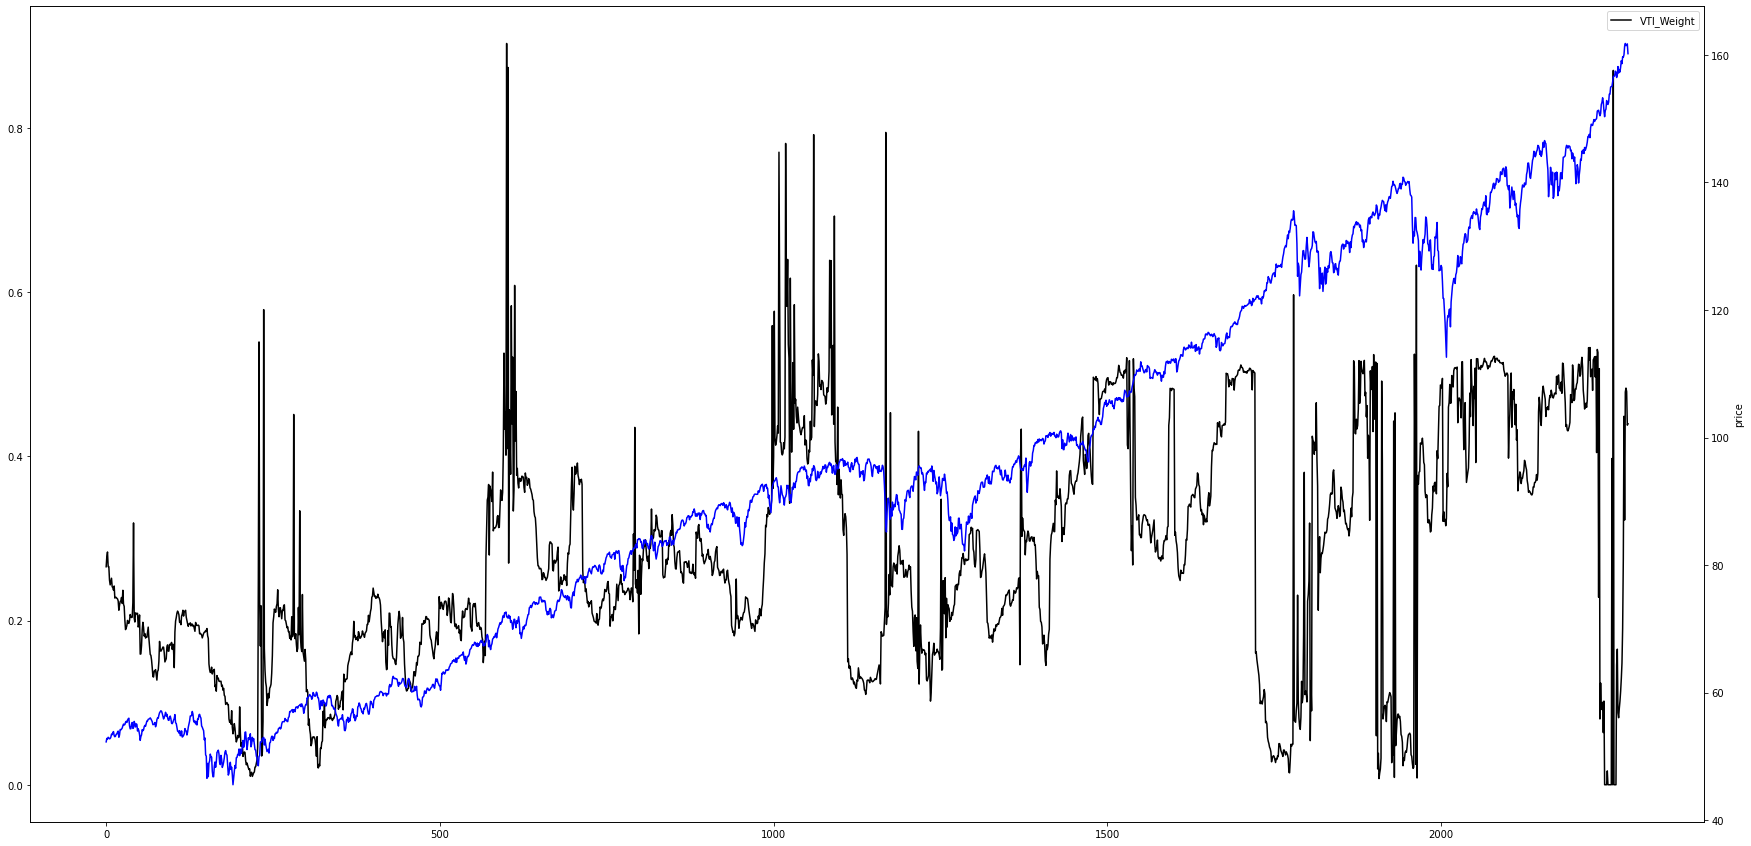

In [ ]:
VTI_data.plot(y='VTI_Weight', color = 'k', figsize=(30, 15))
ax = VTI_data['VTI'].plot(secondary_y=True, color='b')
ax.set_ylabel('price')

plt.show()

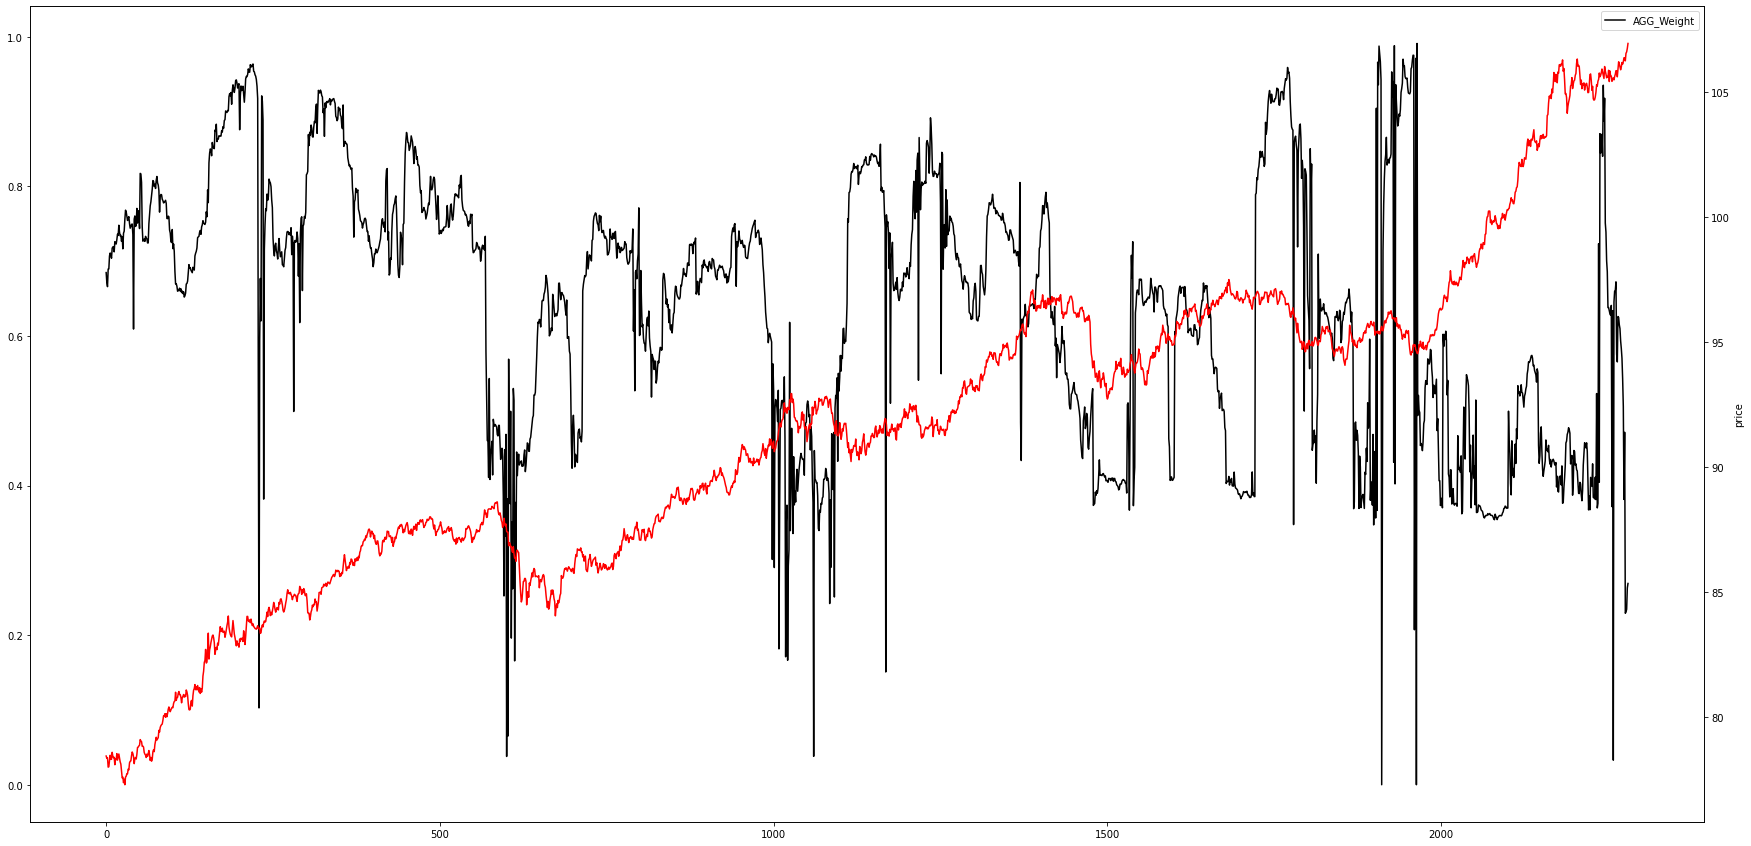

In [ ]:
AGG_data.plot(y='AGG_Weight', color = 'k', figsize=(30, 15))
ax = AGG_data['AGG'].plot(secondary_y=True, color='r')
ax.set_ylabel('price')

plt.show()

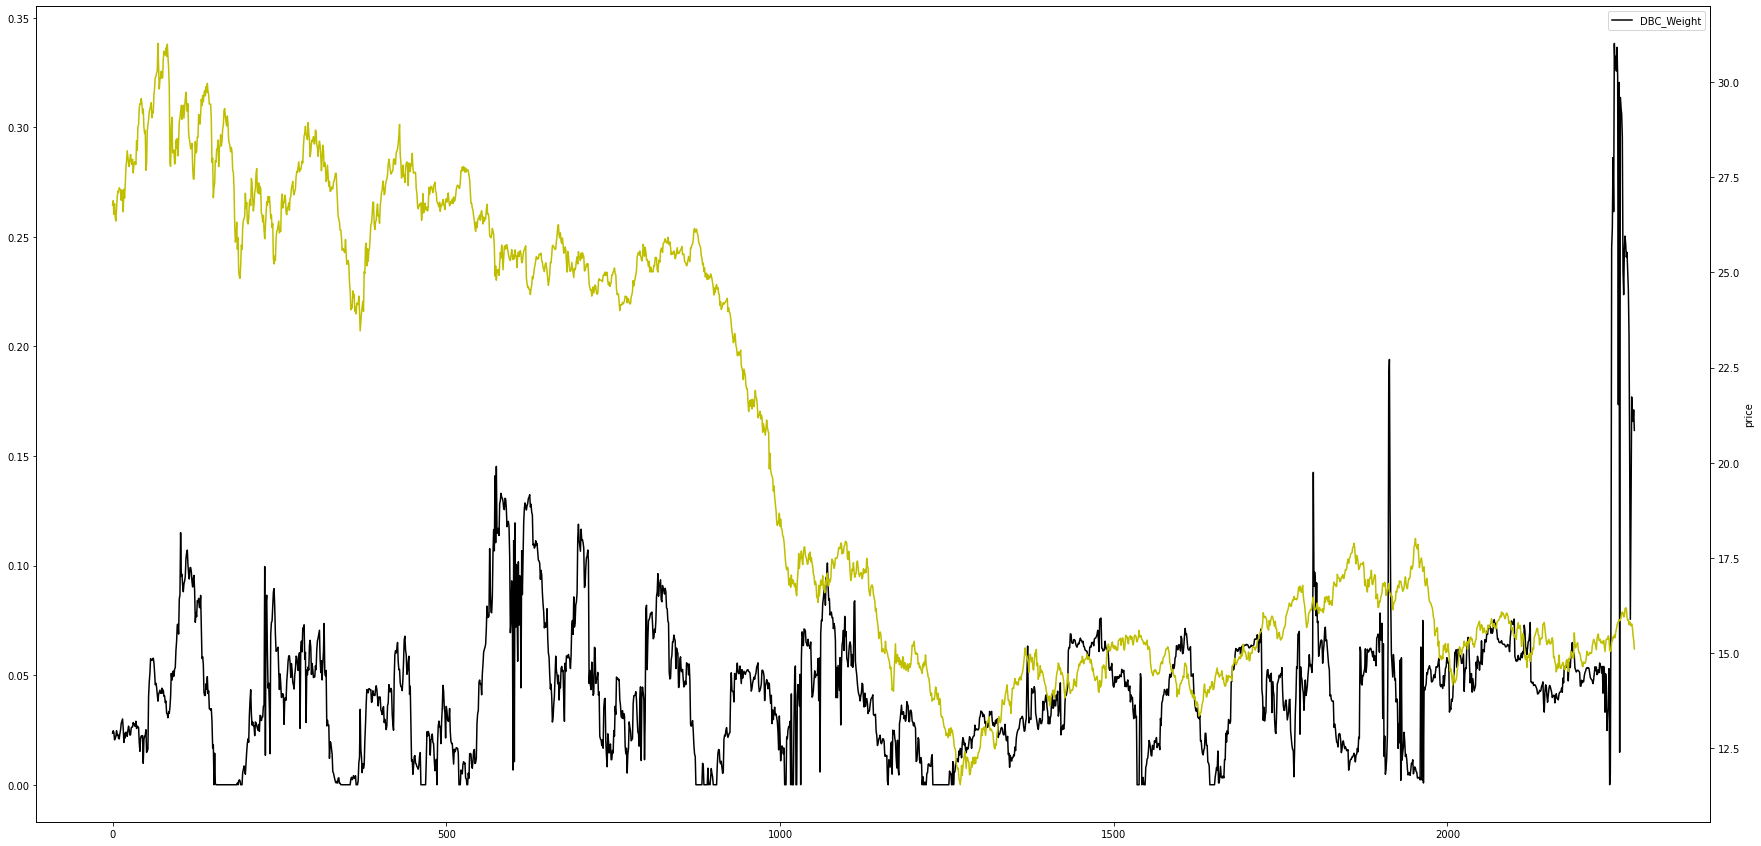

In [ ]:
DBC_data.plot(y='DBC_Weight', color = 'k', figsize=(30, 15))
ax = DBC_data['DBC'].plot(secondary_y=True, color='y')
ax.set_ylabel('price')

plt.show()

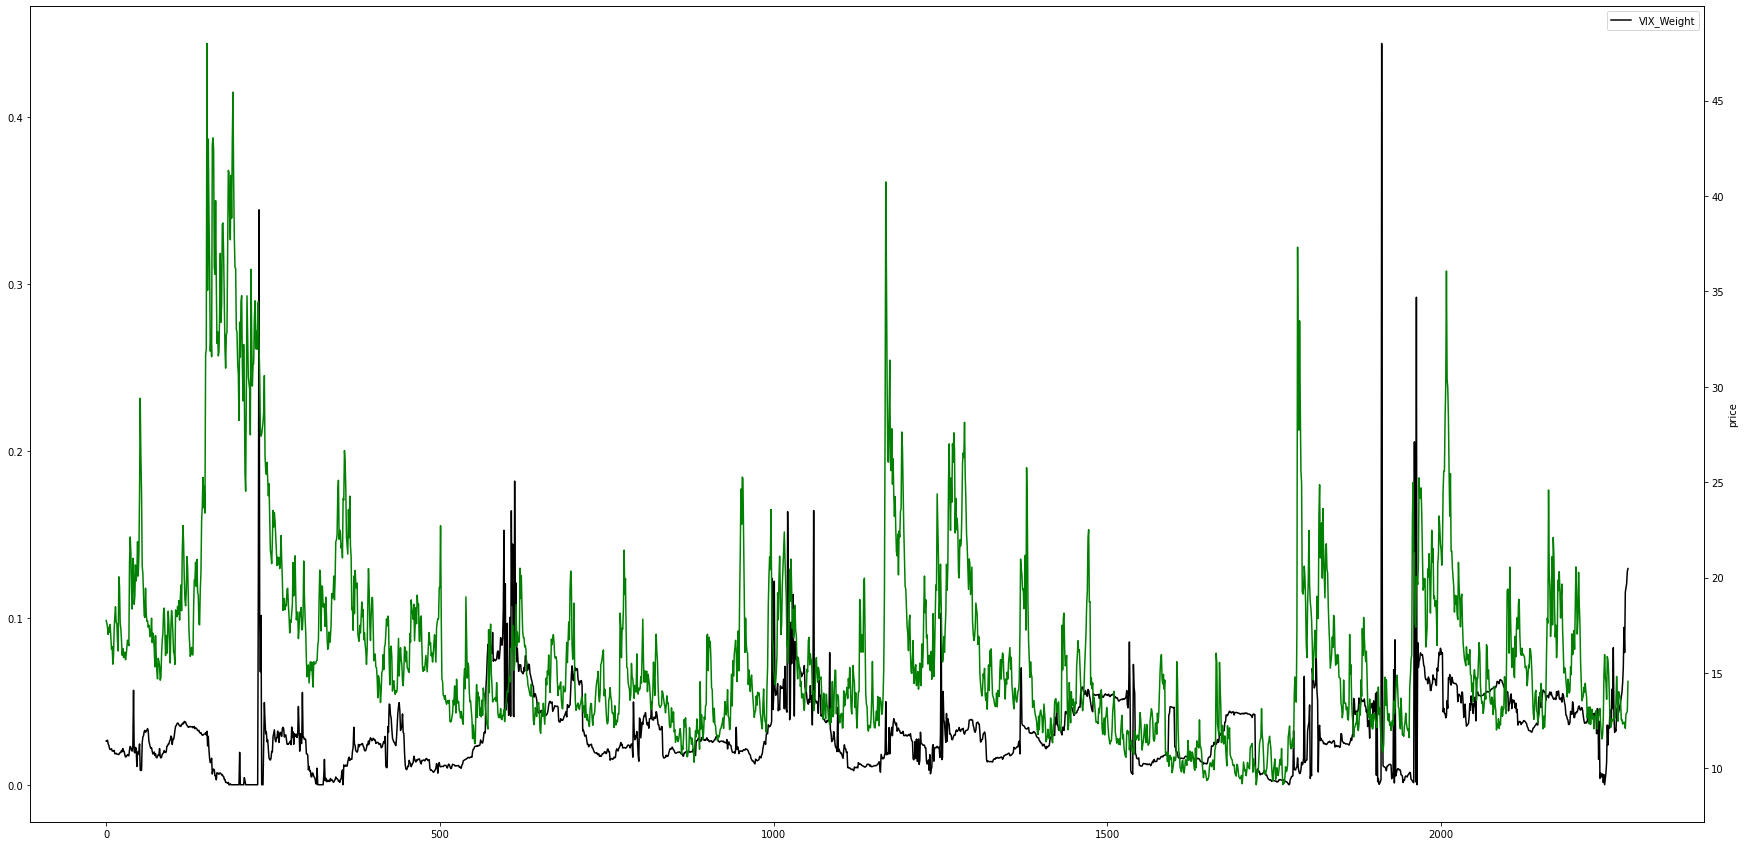

In [ ]:
VIX_data.plot(y='VIX_Weight', color = 'k', figsize=(30, 15))
ax = VIX_data['VIX'].plot(secondary_y=True, color='g')
ax.set_ylabel('price')

plt.show()

In [ ]:
portfolio_E = portfolio_daily_BL_return.mean()
etf_cov = daily_return.cov()
portfolio_stdev = math.sqrt(sigma_2.mean())
portfolio_sharpe = portfolio_E*252 / math.sqrt(sigma_2.mean())

print("\netf_cov:\n", etf_cov)
print("\nportfolio_E:", portfolio_E*252)
print("\nportfolio_stdev:", portfolio_stdev)
print("\nportfolio_sharpe:", portfolio_sharpe)



etf_cov:
           VTI       AGG       DBC       VIX
VTI  0.000120 -0.000003  0.000049 -0.000690
AGG -0.000003  0.000007 -0.000001  0.000028
DBC  0.000049 -0.000001  0.000100 -0.000300
VIX -0.000690  0.000028 -0.000300  0.007216

portfolio_E: 0.08151484390599956

portfolio_stdev: 0.05428654748482269

portfolio_sharpe: 1.501566183202004


In [ ]:
returns_table = pd.concat([implied_equilibrium_returns, BL_return_vector], axis=1) * 100
returns_table.columns = ['Implied Returns', 'BL Return Vector']
returns_table['Difference'] = returns_table['BL Return Vector'] - returns_table['Implied Returns']
returns_table.style.format('{:,.2f}%')

,Implied Returns,BL Return Vector,Difference
VTI,0.01%,-0.01%,-0.02%
AGG,0.00%,0.00%,-0.00%
DBC,0.00%,-0.01%,-0.01%
VIX,0.02%,0.12%,0.10%


In [ ]:
BL_weights_vector = inverse_cov.dot(BL_return_vector)
BL_weights_vector = BL_weights_vector/sum(BL_weights_vector)
MV_weights_vector = inverse_cov.dot(excess_asset_returns.mean())
MV_weights_vector = MV_weights_vector/sum(MV_weights_vector)
weights_table = pd.concat([BL_weights_vector, asset_weights, MV_weights_vector], axis=1) * 100
weights_table.columns = ['BL Weights', 'Market Cap Weights', 'Mean-Var Weights']
weights_table['BL/Mkt Cap Diff'] = weights_table['BL Weights'] - weights_table['Market Cap Weights']
weights_table.style.format('{:,.2f}%')

,BL Weights,Market Cap Weights,Mean-Var Weights,BL/Mkt Cap Diff
VTI,42.25%,44.51%,82.88%,-2.27%
AGG,6.66%,36.12%,55.65%,-29.46%
DBC,11.50%,4.01%,-68.18%,7.49%
VIX,39.59%,15.36%,29.65%,24.23%


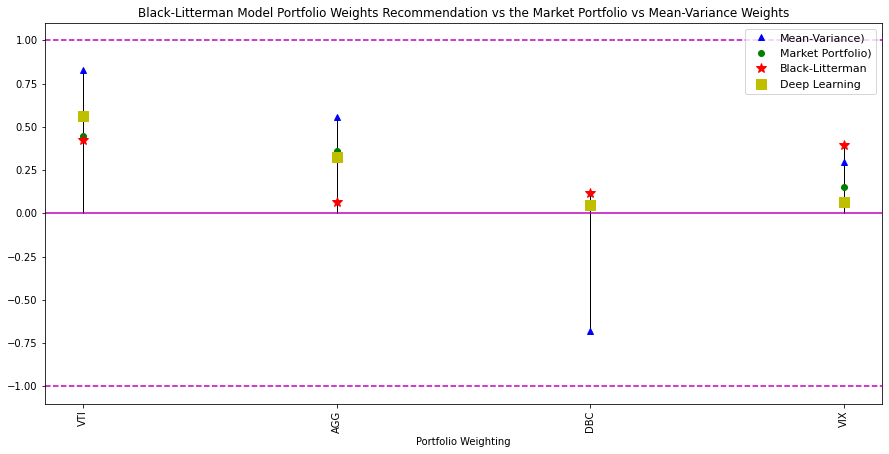

In [ ]:
import matplotlib.pyplot as plt
N = BL_weights_vector.shape[0]
fig, ax = plt.subplots(figsize=(15, 7))
ax.set_title('Black-Litterman Model Portfolio Weights Recommendation vs the Market Portfolio vs Mean-Variance Weights')
ax.plot(np.arange(N)+1, MV_weights_vector, '^', c='b', label='Mean-Variance)')
ax.plot(np.arange(N)+1, asset_weights, 'o', c='g', label='Market Portfolio)')
ax.plot(np.arange(N)+1, BL_weights_vector, '*', c='r',markersize=10, label='Black-Litterman')
ax.plot(np.arange(N)+1, x, 's', c='y',markersize=10, label='Deep Learning')
ax.vlines(np.arange(N)+1, 0, BL_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, MV_weights_vector, lw=1)
ax.vlines(np.arange(N)+1, 0, asset_weights, lw=1)
ax.vlines(np.arange(N)+1, 0, x, lw=1)
ax.axhline(0, c='m')
ax.axhline(-1, c='m', ls='--')
ax.axhline(1, c='m', ls='--')
ax.set_xlabel('Assets')
ax.set_xlabel('Portfolio Weighting')
ax.xaxis.set_ticks(np.arange(1, N+1, 1))
ax.set_xticklabels(asset_weights.index.values)
plt.xticks(rotation=90, )
plt.legend(numpoints=1, fontsize=11)
plt.show()

Post-Presentation Modifications for out-of-sample testing (2020 - 2022)

In [ ]:
# start = datetime.datetime(2006, 1, 1)
# end = datetime.datetime(2010, 12, 31)

start = datetime.datetime(2020,5,1)
end = datetime.datetime(2022,12,1)

# Create daily data csv in sample_data folder for training window: 2006 - 2011
data_2022 = build_dataset(start, end)
print("\nDaily Price Data: 2022\n", data_2022.head())
data_2022.to_csv("sample_data/etf_daily_prices_2022.csv")

# Create daily returns csv in sample_data folder
daily_return_2022 = data_2022.pct_change(1) # 1 for ONE DAY lookback
print("\nDaily Return Data\n", daily_return_2022.head())
daily_return_2022.to_csv("sample_data/etf_daily_returns_2022.csv")

In [ ]:
# start = datetime.datetime(2006, 1, 1)
# end = datetime.datetime(2010, 12, 31)
# start = datetime.datetime(2010,12,31)
# end = datetime.datetime(2020,5,1)
start = datetime.datetime(2020,5,1)
end = datetime.datetime(2022,12,1)
data = build_dataset(start, end)
t = tf.constant(data)
t = tf.cast(t, tf.float32)


model = Model()
x = model.get_allocations(data)

print("\n------------------Assets Allocations based on LSTM Model------------------")
print("Asset List:", [x.split(' ')[0] for x in data.columns])
print("Asset Allocations x:", x)
print("Allocation sum:", sum(x))

Rf = treasury_rate.mean()

daily_return1 = daily_return.iloc[1: , :]
df = (daily_return1*x).T.sum()
R = df.mean()
print("R:", R)

data = np.array([daily_return1.VTI, daily_return1.AGG, daily_return1.DBC, daily_return1.VIX])
cov_matrix = np.cov(data, bias=True)
print(cov_matrix)

portfolio_volatility = np.dot(x.T, np.dot(cov_matrix*252, x))

print(math.sqrt(portfolio_volatility))
sharpe = (R - Rf)*252/math.sqrt(portfolio_volatility)
print("Sharpe Ratio: ", sharpe)